In [ ]:
!pip install patchify

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [ ]:
minmaxscaler = MinMaxScaler()

In [ ]:
dataset_root_folder = '/content/drive/MyDrive/Dataset on semantic segmentation/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_name = 'Semantic segmentation dataset'

In [ ]:
image_patch_size = 256

In [ ]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


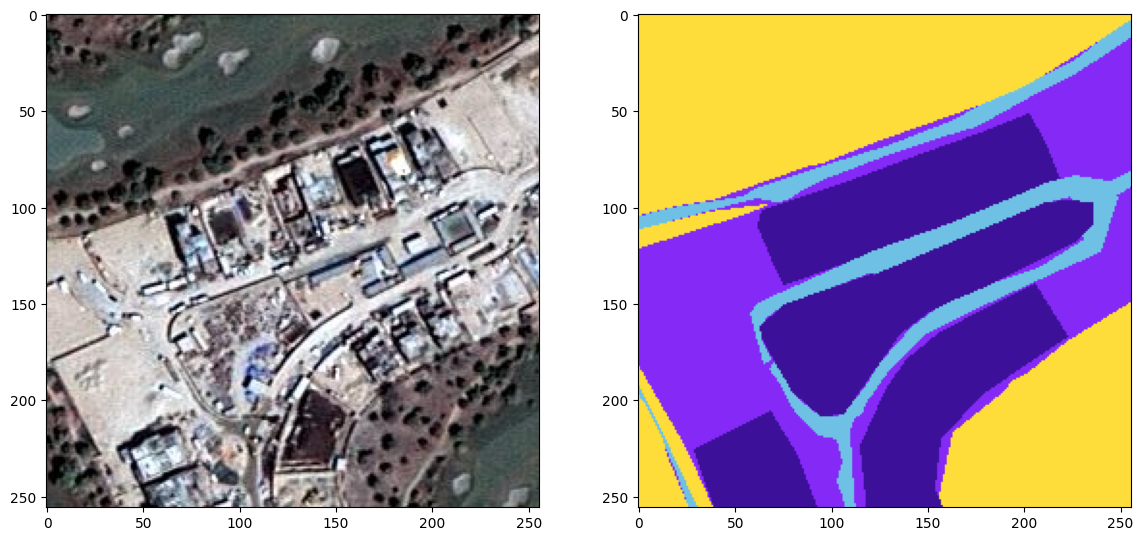

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
label = individual_patched_mask

In [ ]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)


In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


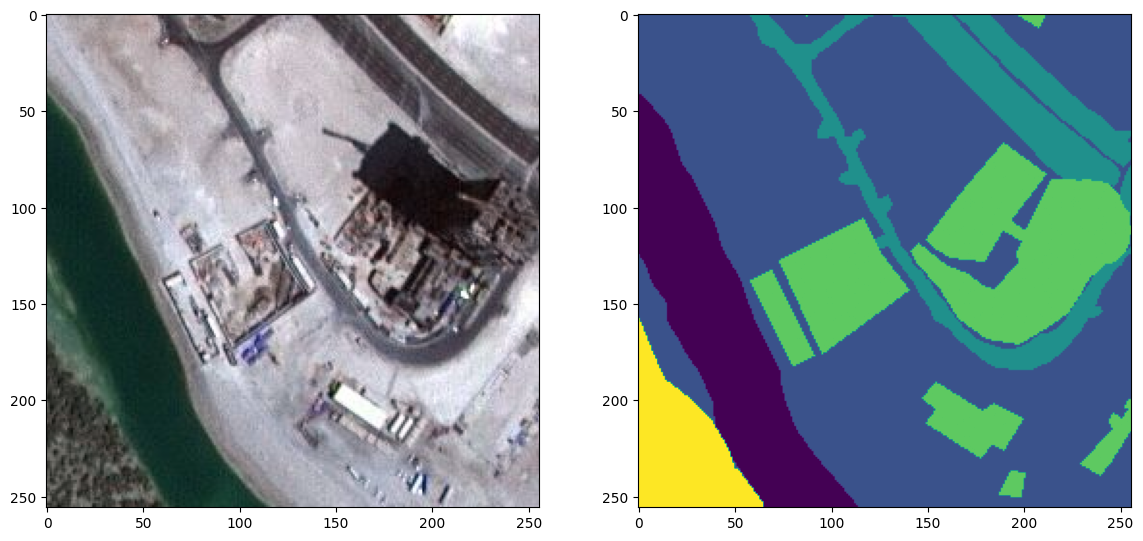

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [ ]:
total_classes = len(np.unique(labels))

In [ ]:
total_classes

6

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [ ]:
master_trianing_dataset = image_dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, SeparableConv2D
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:

from keras import backend as K

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate

def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

    inputs = Input((image_height, image_width, image_channels))
    source_input = inputs

    # Encoder
    c1 = SeparableConv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = SeparableConv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = SeparableConv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = SeparableConv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = SeparableConv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = SeparableConv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = SeparableConv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = SeparableConv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = SeparableConv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = SeparableConv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = SeparableConv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = SeparableConv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = SeparableConv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = SeparableConv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = SeparableConv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = SeparableConv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = SeparableConv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = SeparableConv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

In [ ]:
# Please uncomment this line to get model confiuration
#model.get_config()

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [ ]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-e9n7cy7b
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-e9n7cy7b
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:

!pip install efficientnet segmentation-models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [ ]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:

model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 256, 256, 16)         91        ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 separable_conv2d_1 (Separa  (None, 256, 256, 16)         416       ['separable_conv2d[0][0]']    
 bleConv2D)                                                                                       
                                                                                              

In [ ]:
!pip install tensorflow keras

In [ ]:
from keras.utils import plot_model


In [ ]:
!pip install pydot

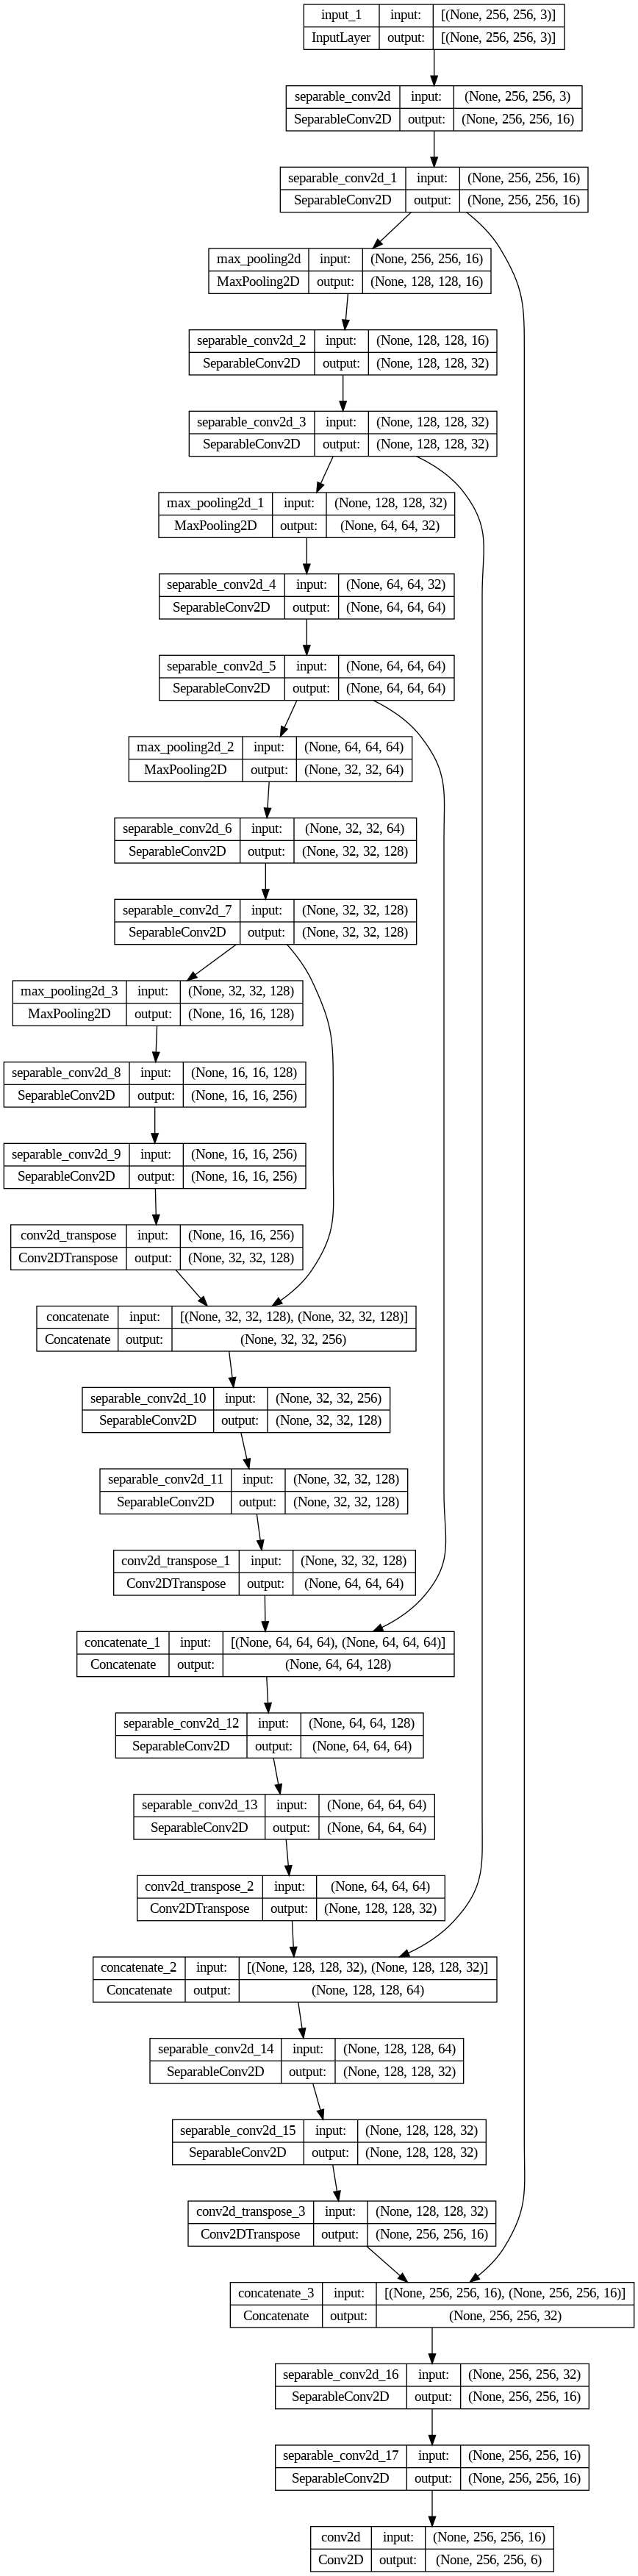

In [ ]:
plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [ ]:
class PlotLoss(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    # self.losses.append(logs.get('loss'))
    # self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    clear_output(wait=True)
    # plt.plot(self.x, self.losses, label="loss")
    # plt.plot(self.x, self.val_losses, label="val_loss")

    plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

    plt.legend()
    plt.show();

plot_loss = PlotLoss()

In [ ]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)

    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

In [ ]:

import tensorflow.keras.backend as K

def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.reshape(y_true, [-1])
    y_pred_flatten = K.reshape(y_pred, [-1])
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value


<Figure size 1400x800 with 0 Axes>

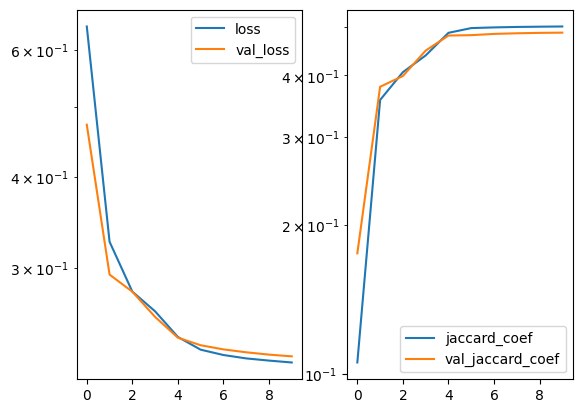

51/51 [==============================] - 8s 164ms/step - loss: 0.2222 - jaccard_coef: 0.5019 - val_loss: 0.2266 - val_jaccard_coef: 0.4878


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[jaccard_coef])

model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],
                          shuffle=False)

In [ ]:
history_a = model_history

In [ ]:
history_a.history

{'loss': [0.6457201242446899,
  0.3260340690612793,
  0.27827587723731995,
  0.261401504278183,
  0.24098093807697296,
  0.23145346343517303,
  0.22756017744541168,
  0.2251204252243042,
  0.22356481850147247,
  0.22223320603370667],
 'jaccard_coef': [0.10551732778549194,
  0.3568977415561676,
  0.4060097634792328,
  0.43879666924476624,
  0.4873259365558624,
  0.49820461869239807,
  0.49978333711624146,
  0.500846803188324,
  0.5014402866363525,
  0.5019443035125732],
 'val_loss': [0.47274038195610046,
  0.29375752806663513,
  0.27820688486099243,
  0.2568035125732422,
  0.2404196560382843,
  0.23472608625888824,
  0.23166000843048096,
  0.22953395545482635,
  0.2278435081243515,
  0.22660426795482635],
 'val_jaccard_coef': [0.17514854669570923,
  0.3794029653072357,
  0.3988417088985443,
  0.44876956939697266,
  0.48124969005584717,
  0.48213815689086914,
  0.48490211367607117,
  0.4863552451133728,
  0.48725223541259766,
  0.48778998851776123]}

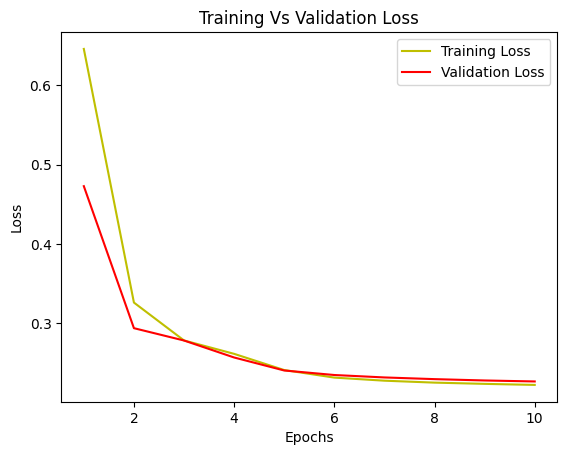

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

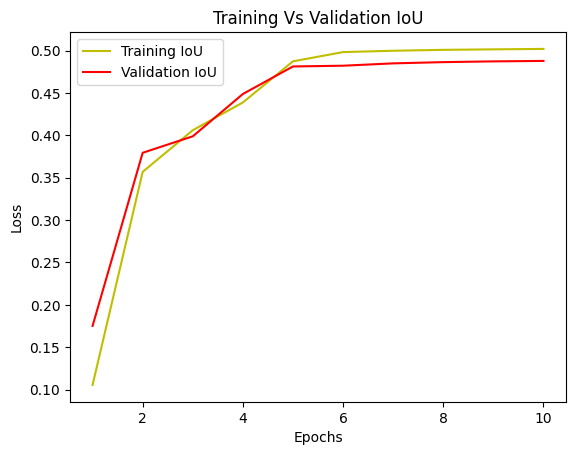

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 51}

In [ ]:
y_pred = model.predict(X_test)

5/5 [==============================] - 3s 64ms/step


In [ ]:
len(y_pred)

142

In [ ]:
y_pred

array([[[[1.00112736e-01, 3.05533022e-01, 1.75931051e-01,
          2.06325471e-01, 1.55248195e-01, 5.68495095e-02],
         [8.22839513e-02, 3.62198442e-01, 1.66451082e-01,
          2.01624542e-01, 1.56327128e-01, 3.11148409e-02],
         [7.64454752e-02, 3.87939423e-01, 1.63265333e-01,
          1.93638548e-01, 1.52357891e-01, 2.63533313e-02],
         ...,
         [1.05697513e-01, 2.83299953e-01, 1.78782165e-01,
          1.89575940e-01, 2.10799709e-01, 3.18446830e-02],
         [1.23265639e-01, 2.56074846e-01, 1.80632070e-01,
          1.81830674e-01, 2.21329093e-01, 3.68677117e-02],
         [1.55898526e-01, 2.22931042e-01, 1.79341748e-01,
          1.65457502e-01, 2.15389848e-01, 6.09812848e-02]],

        [[8.50195512e-02, 3.22319478e-01, 1.63290218e-01,
          2.39579320e-01, 1.60228446e-01, 2.95630172e-02],
         [6.16166666e-02, 3.99758875e-01, 1.43269122e-01,
          2.29334801e-01, 1.55279964e-01, 1.07405260e-02],
         [5.37364893e-02, 4.46470767e-01, 1.3616

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

142

In [ ]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 4],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [4, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [4, 0, 0, ..., 0, 0, 0],
        [4, 4, 0, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0]],

       [[4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 4, 4],
        [4, 4, 4, ..., 1, 1, 4],
        ...,
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
import random

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 1s 787ms/step


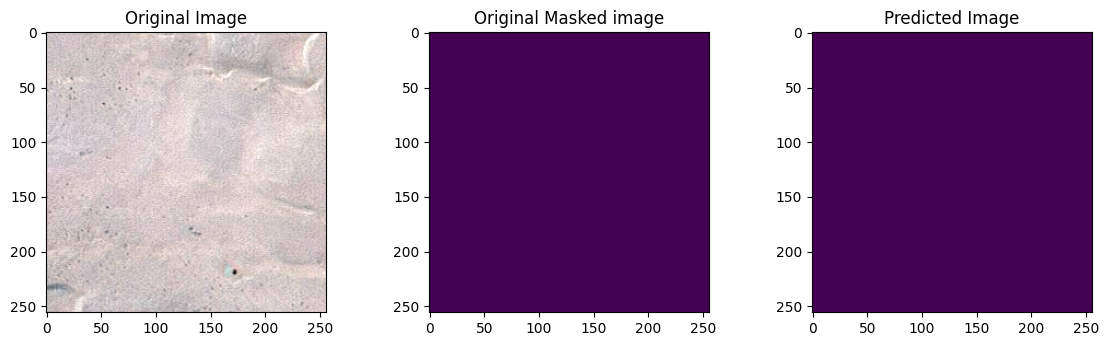

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [ ]:
model.save("satellite_segmentation_full1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls -lah

total 16M
drwxr-xr-x 1 root root 4.0K Jul 23 03:32  .
drwxr-xr-x 1 root root 4.0K Jul 23 03:22  ..
-rw-r--r-- 1 root root 985K Jul 23 03:23 "11°43'22.7N 76°16'21.2E kerala.png"
-rw-r--r-- 1 root root  77K Jul 23 03:23 '13.104339, 78.141312 kolar.jpg'
-rw-r--r-- 1 root root 131K Jul 23 03:23 '13.110695, 78.165965 Kolar.jpg'
-rw-r--r-- 1 root root 1.2M Jul 23 03:23 "14°15'58.7S 49°35'31.6E madagascar.png"
-rw-r--r-- 1 root root 648K Jul 23 03:23 "19°01'02.3N 98°06'53.4W PEUBLA.png"
-rw-r--r-- 1 root root  89K Jul 23 03:23 '19.120291, -96.162418 mexico jiamca.jpg'
-rw-r--r-- 1 root root 963K Jul 23 03:23 "19°21'29.7N 102°04'35.9W uruapan.png"
-rw-r--r-- 1 root root 1.1M Jul 23 03:23 "19°24'10.6N 102°02'50.2W MICHAOCAN.png"
-rw-r--r-- 1 root root 112K Jul 23 03:23 '19.643277, -96.915946 chayote mexico.jpg'
-rw-r--r-- 1 root root 638K Jul 23 03:23 "21°03'04.1S 55°32'02.8E reunion.png"
-rw-r--r-- 1 root root 1.2M Jul 23 03:23 "23°51'18.8S 30°06'31.2E sotuh africA.png"
-rw-r--r-- 1 root root 

In [ ]:
plt.imsave('predicted_image.png', predicted_image)

1/1 [==============================] - 0s 302ms/step


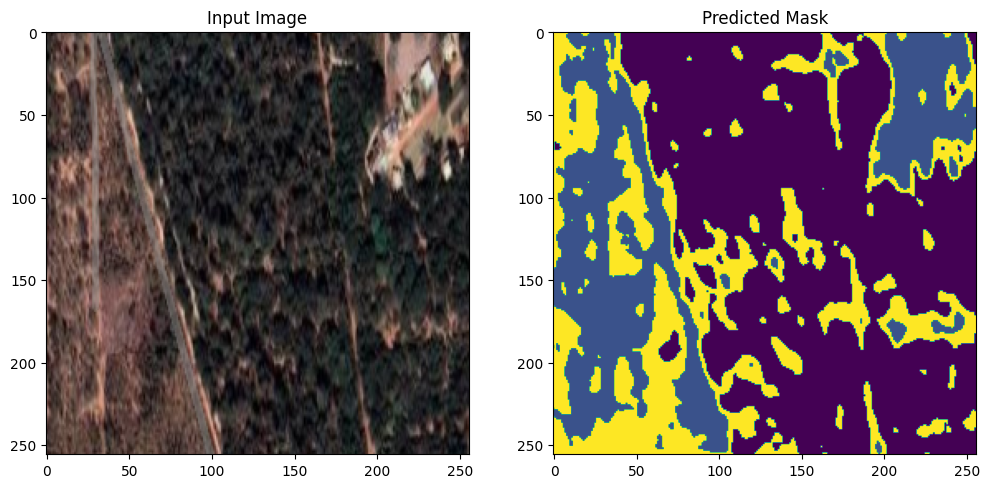

In [ ]:
import tensorflow as tf

# Define the custom metric
def jaccard_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + 1.0) / (sum_ - intersection + 1.0)
    return jac

# Load the model with the custom metric
model = tf.keras.models.load_model("satellite_segmentation_full1.h5", custom_objects={'jaccard_coef': jaccard_coef})

# Load the input image
input_image = plt.imread('/content/13.104339, 78.141312 kolar.jpg')

# Preprocess the input image
input_image = plt.imread('/content/13.104339, 78.141312 kolar.jpg')
input_image = tf.image.resize(input_image, (256, 256))
input_image = input_image / 255.0
input_image = np.expand_dims(input_image, 0)

# Make a prediction on the input image
prediction = model.predict(input_image)

# Get the predicted mask
predicted_mask = np.argmax(prediction, axis=3)
predicted_mask = predicted_mask[0,:,:]

# Display the input image and predicted mask
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Input Image")
plt.imshow(input_image[0,:,:,:])
plt.subplot(122)
plt.title("Predicted Mask")
plt.imshow(predicted_mask)

plt.savefig('prediction_result.png')

plt.imsave('predicted_mask.png', predicted_mask)

1/1 [==============================] - 1s 1s/step


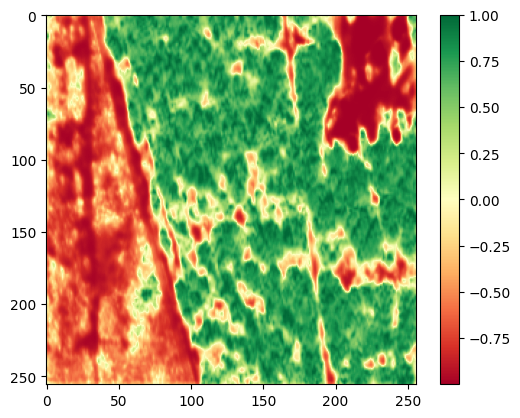

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load your pretrained model for NIR prediction
def jaccard_coef(y_true, y_pred):
    # Dummy function, replace with your actual function if needed
    return tf.reduce_mean(y_true * y_pred)

model = tf.keras.models.load_model("satellite_segmentation_full1.h5", custom_objects={'jaccard_coef': jaccard_coef})

# Load and preprocess the RGB image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Resize to the size your model expects
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Predict the NIR band from the RGB image
def predict_nir(model, rgb_image):
    nir_prediction = model.predict(np.expand_dims(rgb_image, axis=0))[0]
    # Ensure the NIR prediction is a single channel
    if nir_prediction.shape[-1] > 1:
        nir_prediction = nir_prediction[..., 0]  # Select the first channel if multiple
    nir_prediction = np.squeeze(nir_prediction)  # Remove any extra dimensions
    return nir_prediction

# Calculate NDVI
def calculate_ndvi(nir, red):
    ndvi = (nir - red) / (nir + red)
    return np.nan_to_num(ndvi)  # Handle potential NaN values

# Example usage
rgb_image = preprocess_image('/content/13.104339, 78.141312 kolar.jpg')
nir_band = predict_nir(model, rgb_image)
red_band = rgb_image[:, :, 0]  # Assuming the red band is the first channel

# Calculate NDVI
ndvi = calculate_ndvi(nir_band, red_band)

# Display the NDVI image
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.show()

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 35.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from rasterio import Affine

# Load your pretrained model for NIR prediction
def jaccard_coef(y_true, y_pred):
    # Dummy function, replace with your actual function if needed
    return tf.reduce_mean(y_true * y_pred)

model = tf.keras.models.load_model("satellite_segmentation_full1.h5", custom_objects={'jaccard_coef': jaccard_coef})

# Load and preprocess the RGB image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Resize to the size your model expects
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Predict the NIR band from the RGB image
def predict_nir(model, rgb_image):
    nir_prediction = model.predict(np.expand_dims(rgb_image, axis=0))[0]
    # Ensure the NIR prediction is a single channel
    if nir_prediction.shape[-1] > 1:
        nir_prediction = nir_prediction[..., 0]  # Select the first channel if multiple
    nir_prediction = np.squeeze(nir_prediction)  # Remove any extra dimensions
    return nir_prediction

# Calculate NDVI
def calculate_ndvi(nir, red):
    ndvi = (nir - red) / (nir + red)
    return np.nan_to_num(ndvi)  # Handle potential NaN values

# Example usage
rgb_image = preprocess_image('/content/13.104339, 78.141312 kolar.jpg')
nir_band = predict_nir(model, rgb_image)
red_band = rgb_image[:, :, 0]  # Assuming the red band is the first channel

# Calculate NDVI
ndvi = calculate_ndvi(nir_band, red_band)

# Save NDVI as GeoTIFF
output_file = "ndvi_output1.tif"
# Define metadata for GeoTIFF
transform = from_origin(0, 0, 1, 1)  # Define transformation (adjust as per your data)
profile = {
    'driver': 'GTiff',
    'dtype': ndvi.dtype,
    'height': ndvi.shape[0],
    'width': ndvi.shape[1],
    'count': 1,
    'crs': 'EPSG:4326',  # Coordinate Reference System (adjust as per your data)
    'transform': transform
}

# Write NDVI array to GeoTIFF file
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(ndvi, 1)

print(f"NDVI saved to {output_file}")


1/1 [==============================] - 0s 328ms/step
NDVI saved to ndvi_output1.tif


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [ ]:
import numpy as np
import matplotlib.cm as cm

# Assume ndvi is a 2D array of NDVI values

# Normalize the NDVI values to the range [0, 1]
ndvi_normalized = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())

# Create a colormap object
cmap = cm.get_cmap('RdYlGn')  # Choose a colormap, e.g. RdYlGn for a red-yellow-green palette

# Map the NDVI values to colors using the colormap
rgb_image = cmap(ndvi_normalized)[:, :, :3]  # Extract the RGB channels

# Convert the RGB image to uint8 format
rgb_image = (rgb_image * 255).astype(np.uint8)

# Save the color image to a file
Image.fromarray(rgb_image).save('ndvi_color_image.jpg')

<ipython-input-84-4eb75b55d3c8>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')  # Choose a colormap, e.g. RdYlGn for a red-yellow-green palette


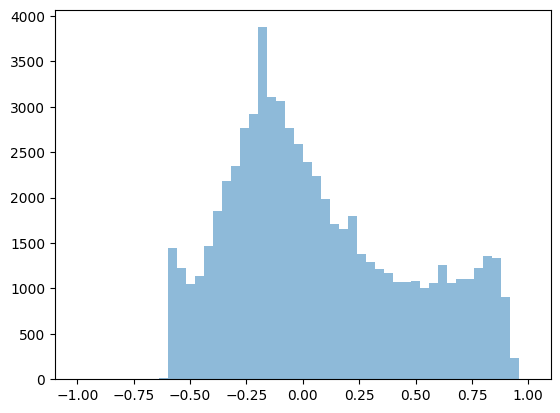

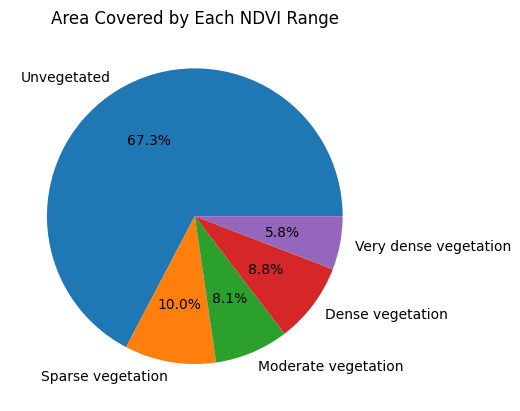

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the JPG image
img = cv2.imread('ndvi_color_image.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Normalize the pixel values to the range [-1, 1]
ndvi_image = (gray / 255.0) * 2 - 1

# Define the NDVI ranges
ndvi_ranges = [
  { 'min': -1, 'max': 0.2, 'label': 'Unvegetated' },
  { 'min': 0.2, 'max': 0.4, 'label': 'Sparse vegetation' },
  { 'min': 0.4, 'max': 0.6, 'label': 'Moderate vegetation' },
  { 'min': 0.6, 'max': 0.8, 'label': 'Dense vegetation' },
  { 'min': 0.8, 'max': 1, 'label': 'Very dense vegetation' }
]

# Calculate the histogram of NDVI values
hist, bins = np.histogram(ndvi_image.flatten(), bins=50, range=(-1, 1))

# Calculate the area covered by each NDVI range
areas = []
for r in ndvi_ranges:
  mask = (ndvi_image >= r['min']) & (ndvi_image < r['max'])
  area = np.sum(mask) * (ndvi_image.shape[0] * ndvi_image.shape[1]) / (ndvi_image.shape[0] * ndvi_image.shape[1])
  areas.append(area)

# Plot the histogram
plt.hist(bins[:-1], bins, weights=hist, alpha=0.5, label='NDVI values')

# Create a new figure for the pie chart
plt.figure()

# Plot the area covered by each NDVI range as a pie chart
plt.pie(areas, labels=[r['label'] for r in ndvi_ranges], autopct='%1.1f%%')
plt.title('Area Covered by Each NDVI Range')

# Show the plot
plt.show()

1/1 [==============================] - 1s 559ms/step


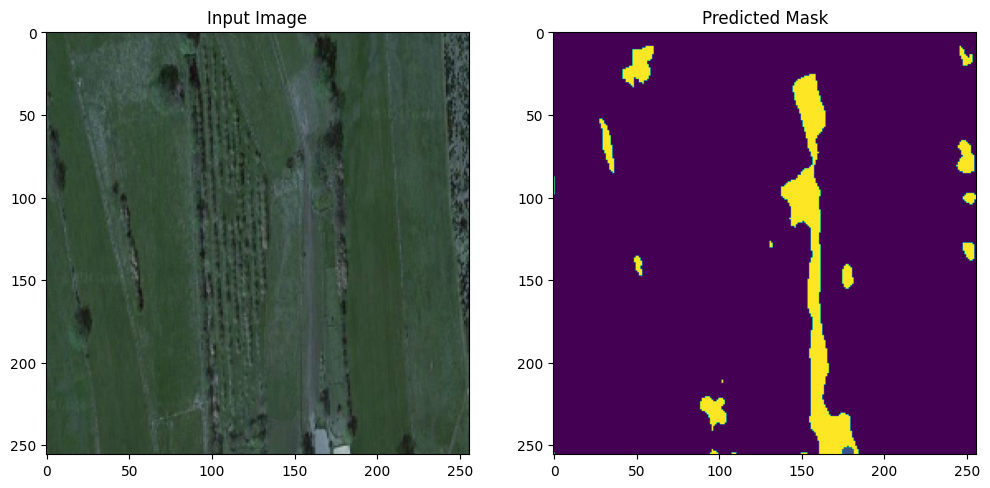

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the custom metric
def jaccard_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + 1.0) / (sum_ - intersection + 1.0)
    return jac

# Load the model with the custom metric
model = tf.keras.models.load_model("satellite_segmentation_full1.h5", custom_objects={'jaccard_coef': jaccard_coef})

# Load the input image
input_image = cv2.imread("/content/52.474687, 9.842951 germany asparagus.jpg")

# Convert the input image to RGB mode
input_image = cv2.cvtColor(input_image, cv2.COLOR_RGBA2RGB)

# Preprocess the input image
input_image = tf.image.resize(input_image, (256, 256))
input_image = input_image / 255.0
input_image = np.expand_dims(input_image, 0)

# Make a prediction on the input image
prediction = model.predict(input_image)

# Get the predicted mask
predicted_mask = np.argmax(prediction, axis=3)
predicted_mask = predicted_mask[0,:,:]

# Display the input image and predicted mask
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Input Image")
plt.imshow(input_image[0,:,:,:])
plt.subplot(122)
plt.title("Predicted Mask")
plt.imshow(predicted_mask)

plt.savefig('prediction_result_2.png')

plt.imsave('predicted_mask_2.png', predicted_mask)

1/1 [==============================] - 1s 537ms/step


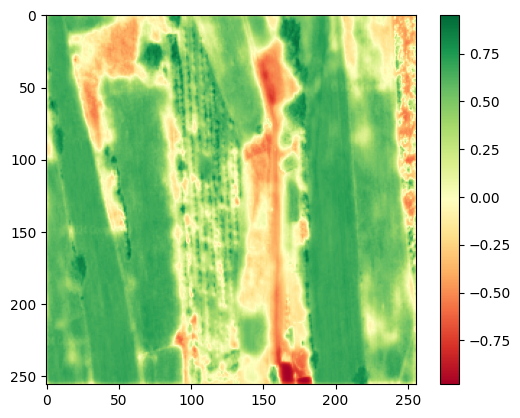

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load your pretrained model for NIR prediction
def jaccard_coef(y_true, y_pred):
    # Dummy function, replace with your actual function if needed
    return tf.reduce_mean(y_true * y_pred)

model = tf.keras.models.load_model("satellite_segmentation_full1.h5", custom_objects={'jaccard_coef': jaccard_coef})

# Load and preprocess the RGB image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    image = image.resize((256, 256))  # Resize to the size your model expects
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Predict the NIR band from the RGB image
def predict_nir(model, rgb_image):
    nir_prediction = model.predict(np.expand_dims(rgb_image, axis=0))[0]
    # Ensure the NIR prediction is a single channel
    if nir_prediction.shape[-1] > 1:
        nir_prediction = nir_prediction[..., 0]  # Select the first channel if multiple
    nir_prediction = np.squeeze(nir_prediction)  # Remove any extra dimensions
    return nir_prediction

# Calculate NDVI
def calculate_ndvi(nir, red):
    ndvi = (nir - red) / (nir + red)
    return np.nan_to_num(ndvi)  # Handle potential NaN values

# Example usage
rgb_image = preprocess_image("/content/52.474687, 9.842951 germany asparagus.jpg")
nir_band = predict_nir(model, rgb_image)
red_band = rgb_image[:, :, 0]  # Assuming the red band is the first channel

# Calculate NDVI
ndvi = calculate_ndvi(nir_band, red_band)

# Display the NDVI image
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.show()

In [ ]:
!pip install rasterio

1/1 [==============================] - 1s 558ms/step
NDVI saved to ndvi_output2.tif


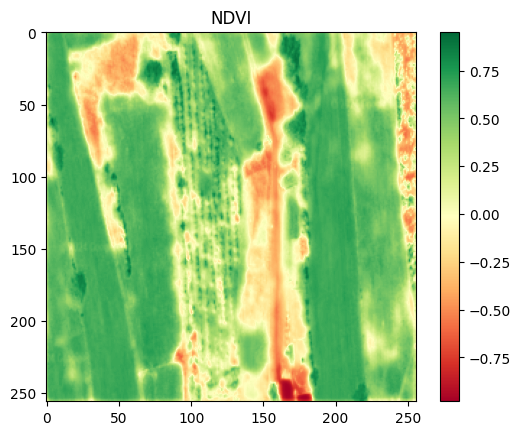

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from rasterio import Affine

# Load your pretrained model for NIR prediction
def jaccard_coef(y_true, y_pred):
    # Dummy function, replace with your actual function if needed
    return tf.reduce_mean(y_true * y_pred)

model = tf.keras.models.load_model("satellite_segmentation_full1.h5", custom_objects={'jaccard_coef': jaccard_coef})

# Load and preprocess the RGB image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    image = image.resize((256, 256))  # Resize to the size your model expects
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Predict the NIR band from the RGB image
def predict_nir(model, rgb_image):
    nir_prediction = model.predict(np.expand_dims(rgb_image, axis=0))[0]
    # Ensure the NIR prediction is a single channel
    if nir_prediction.shape[-1] > 1:
        nir_prediction = nir_prediction[..., 0]  # Select the first channel if multiple
    nir_prediction = np.squeeze(nir_prediction)  # Remove any extra dimensions
    return nir_prediction

# Calculate NDVI
def calculate_ndvi(nir, red):
    ndvi = (nir - red) / (nir + red)
    return np.nan_to_num(ndvi)  # Handle potential NaN values

# Example usage
rgb_image = preprocess_image("/content/52.474687, 9.842951 germany asparagus.jpg")
nir_band = predict_nir(model, rgb_image)
red_band = rgb_image[:, :, 0]  # Assuming the red band is the first channel

# Calculate NDVI
ndvi = calculate_ndvi(nir_band, red_band)

# Save NDVI as GeoTIFF
output_file = "ndvi_output2.tif"
with rasterio.open(output_file, 'w', driver='GTiff', width=ndvi.shape[1], height=ndvi.shape[0], count=1, dtype=ndvi.dtype) as dst:
    dst.write(ndvi, 1)

print(f"NDVI saved to {output_file}")

# Display the NDVI image
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI')
plt.show()

In [ ]:
import numpy as np
import matplotlib.cm as cm

# Assume ndvi is a 2D array of NDVI values

# Normalize the NDVI values to the range [0, 1]
ndvi_normalized = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())

# Create a colormap object
cmap = cm.get_cmap('RdYlGn')  # Choose a colormap, e.g. RdYlGn for a red-yellow-green palette

# Map the NDVI values to colors using the colormap
rgb_image = cmap(ndvi_normalized)[:, :, :3]  # Extract the RGB channels

# Convert the RGB image to uint8 format
rgb_image = (rgb_image * 255).astype(np.uint8)

# Save the color image to a file
Image.fromarray(rgb_image).save('ndvi_color_image2.jpg')

<ipython-input-160-058204f252dc>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')  # Choose a colormap, e.g. RdYlGn for a red-yellow-green palette


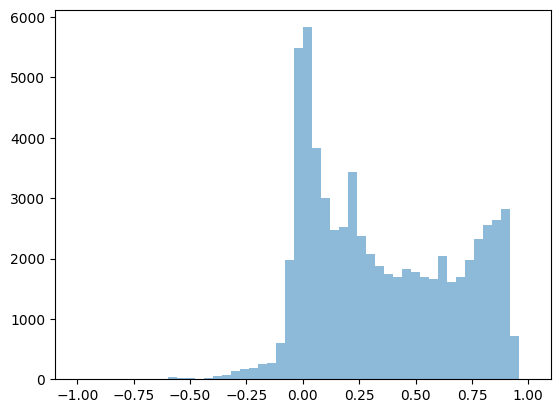

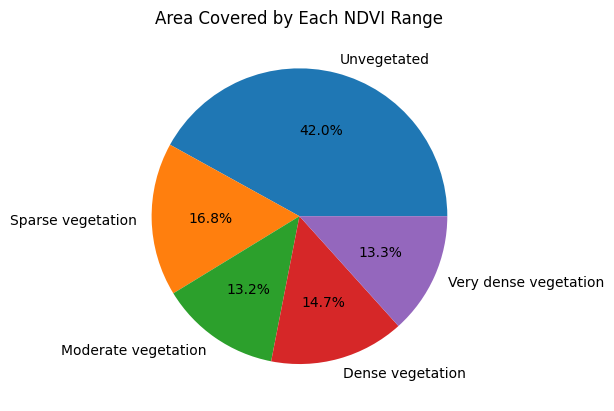

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the JPG image
img = cv2.imread('ndvi_color_image2.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Normalize the pixel values to the range [-1, 1]
ndvi_image = (gray / 255.0) * 2 - 1

# Define the NDVI ranges
ndvi_ranges = [
  { 'min': -1, 'max': 0.2, 'label': 'Unvegetated' },
  { 'min': 0.2, 'max': 0.4, 'label': 'Sparse vegetation' },
  { 'min': 0.4, 'max': 0.6, 'label': 'Moderate vegetation' },
  { 'min': 0.6, 'max': 0.8, 'label': 'Dense vegetation' },
  { 'min': 0.8, 'max': 1, 'label': 'Very dense vegetation' }
]

# Calculate the histogram of NDVI values
hist, bins = np.histogram(ndvi_image.flatten(), bins=50, range=(-1, 1))

# Calculate the area covered by each NDVI range
areas = []
for r in ndvi_ranges:
  mask = (ndvi_image >= r['min']) & (ndvi_image < r['max'])
  area = np.sum(mask) * (ndvi_image.shape[0] * ndvi_image.shape[1]) / (ndvi_image.shape[0] * ndvi_image.shape[1])
  areas.append(area)

# Plot the histogram
plt.hist(bins[:-1], bins, weights=hist, alpha=0.5, label='NDVI values')

# Create a new figure for the pie chart
plt.figure()

# Plot the area covered by each NDVI range as a pie chart
plt.pie(areas, labels=[r['label'] for r in ndvi_ranges], autopct='%1.1f%%')
plt.title('Area Covered by Each NDVI Range')

# Show the plot
plt.show()

In [ ]:
"""import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(-1, 784) / 255.0, x_test.reshape(-1, 784) / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(784,)),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate multiple times
num_runs = 5
accuracies = []

for i in range(num_runs):
    model = create_model()
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(accuracy)
    print(f'Run {i+1} - Test Accuracy: {accuracy:.4f}')

# Plot accuracies
plt.plot(range(1, num_runs+1, 1), accuracies, marker='o')
plt.title('Test Accuracy over Multiple Runs')
plt.xlabel('Run')
plt.ylabel('Test Accuracy')
plt.show()

print(f'Mean Accuracy: {np.mean(accuracies):.4f}')
print(f'Standard Deviation of Accuracy: {np.std(accuracies):.4f}')
"""

"import numpy as np\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\nfrom tensorflow.keras.datasets import mnist\nfrom tensorflow.keras.utils import to_categorical\nimport matplotlib.pyplot as plt\n\n# Load and preprocess data\n(x_train, y_train), (x_test, y_test) = mnist.load_data()\nx_train, x_test = x_train.reshape(-1, 784) / 255.0, x_test.reshape(-1, 784) / 255.0\ny_train, y_test = to_categorical(y_train), to_categorical(y_test)\n\ndef create_model():\n    model = Sequential([\n        Dense(128, activation='relu', input_shape=(784,)),\n        Dense(10, activation='softmax')\n    ])\n    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n    return model\n\n# Train and evaluate multiple times\nnum_runs = 5\naccuracies = []\n\nfor i in range(num_runs):\n    model = create_model()\n    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)\n    loss, accuracy = model.evaluate(x_test, y_test, ver

Mean NDVI: 0.12247114611420767
Median NDVI: 0.349581513850473
Standard Deviation of NDVI: 0.6716973883141723


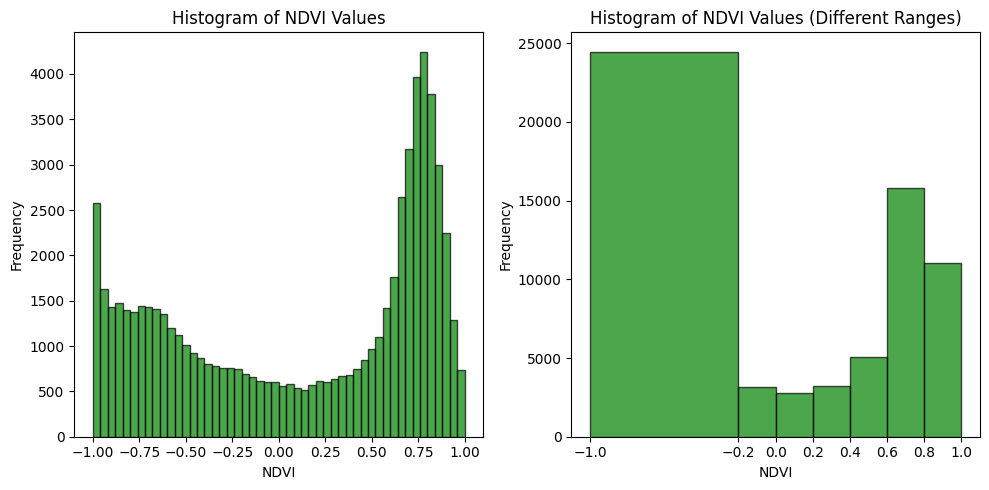

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the NDVI image
ndvi_image_path = 'ndvi_output1.tif'
with rasterio.open(ndvi_image_path) as src:
    ndvi = src.read(1)  # Read the first band

# Calculate statistics for the entire NDVI image
mean_ndvi = np.mean(ndvi)
median_ndvi = np.median(ndvi)
std_ndvi = np.std(ndvi)

# Print the statistics
print(f'Mean NDVI: {mean_ndvi}')
print(f'Median NDVI: {median_ndvi}')
print(f'Standard Deviation of NDVI: {std_ndvi}')

# Plot histogram of NDVI values
plt.figure(figsize=(10, 5))

# Plot histogram for entire image
plt.subplot(1, 2, 1)
plt.hist(ndvi.flatten(), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Histogram of NDVI Values')
plt.xlabel('NDVI')
plt.ylabel('Frequency')

# Plot histogram for different NDVI ranges
plt.subplot(1, 2, 2)
bins = [-1, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]  # Define bins for different NDVI ranges
plt.hist(ndvi.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='green')
plt.title('Histogram of NDVI Values (Different Ranges)')
plt.xlabel('NDVI')
plt.ylabel('Frequency')

# Customize x-axis labels to show bin ranges
plt.xticks(bins)

plt.tight_layout()
plt.show()

Mean NDVI: 0.3498255861416334
Median NDVI: 0.4926252943365784
Standard Deviation of NDVI: 0.3508216301775201


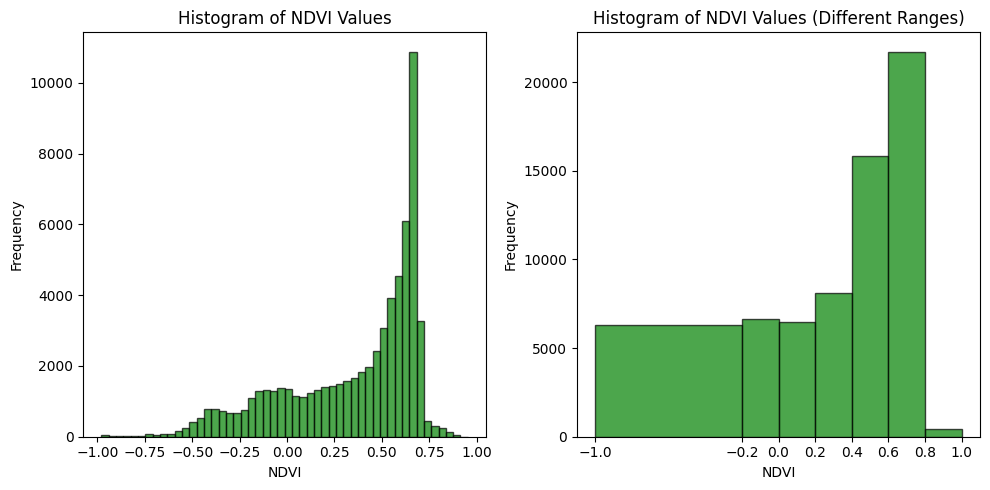

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the NDVI image
ndvi_image_path = 'ndvi_output2.tif'
with rasterio.open(ndvi_image_path) as src:
    ndvi = src.read(1)  # Read the first band

# Calculate statistics for the entire NDVI image
mean_ndvi = np.mean(ndvi)
median_ndvi = np.median(ndvi)
std_ndvi = np.std(ndvi)

# Print the statistics
print(f'Mean NDVI: {mean_ndvi}')
print(f'Median NDVI: {median_ndvi}')
print(f'Standard Deviation of NDVI: {std_ndvi}')

# Plot histogram of NDVI values
plt.figure(figsize=(10, 5))

# Plot histogram for entire image
plt.subplot(1, 2, 1)
plt.hist(ndvi.flatten(), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Histogram of NDVI Values')
plt.xlabel('NDVI')
plt.ylabel('Frequency')

# Plot histogram for different NDVI ranges
plt.subplot(1, 2, 2)
bins = [-1, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]  # Define bins for different NDVI ranges
plt.hist(ndvi.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='green')
plt.title('Histogram of NDVI Values (Different Ranges)')
plt.xlabel('NDVI')
plt.ylabel('Frequency')

# Customize x-axis labels to show bin ranges
plt.xticks(bins)

plt.tight_layout()
plt.show()

In [ ]:
!pip install requests

In [ ]:
!pip install tabulate

In [ ]:
import requests
from tabulate import tabulate
from datetime import datetime, timedelta

# Your Tomorrow.io API key
api_key = 'qbSV5dCwZ1n1PyNlcy1a9oH0cd9X7cAj'

# Base URL for the Tomorrow.io API
base_url = 'https://api.tomorrow.io/v4/timelines'

# Calculate start and end times
start_time = datetime.now().isoformat()  # current time
end_time = (datetime.now() + timedelta(days=5)).isoformat()  # 7 days from now

# Parameters for the request
params = {
    'apikey': api_key,
    'location': '13.1377,78.1297',  # Coordinates for Kolar, Karnataka
    'fields': ['temperature', 'precipitationProbability'],
    'timesteps': '1h',
    'startTime': start_time,
    'endTime': end_time
}

# Make the request to Tomorrow.io API
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    timeline_intervals = data['data']['timelines'][0]['intervals']
    table_data = []

    for interval in timeline_intervals:
        time = interval['startTime']
        temperature = interval['values']['temperature']
        precipitation = interval['values']['precipitationProbability']
        table_data.append([time, temperature, precipitation])

    # Define table headers
    headers = ["Time", "Temperature (°C)", "Precipitation Probability (%)"]

    # Print table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
else:
    print(f'Error: {response.status_code}, {response.text}')

+----------------------+--------------------+---------------------------------+
| Time                 |   Temperature (°C) |   Precipitation Probability (%) |
+======================+====================+=================================+
| 2024-07-23T03:00:00Z |              24.63 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T04:00:00Z |              24.52 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T05:00:00Z |              25.17 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T06:00:00Z |              27.03 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T07:00:00Z |              27.09 |                               0 |
+----------------------+----------------

In [ ]:
import requests
from datetime import datetime, timedelta
from tabulate import tabulate

# Your Tomorrow.io API key
api_key = 'qbSV5dCwZ1n1PyNlcy1a9oH0cd9X7cAj'

# Base URL for the Tomorrow.io API
base_url = 'https://api.tomorrow.io/v4/timelines'

# Calculate start and end times
start_time = datetime.now().isoformat()  # current time
end_time = (datetime.now() + timedelta(days=5)).isoformat()  # 5 days from now

# Parameters for the request
params = {
    'apikey': api_key,
    'location': '13.1377,78.1297',  # Coordinates for Kolar, Karnataka
    'fields': ['temperature', 'precipitationProbability'],
    'timesteps': '1h',
    'startTime': start_time,
    'endTime': end_time
}

# Make the request to Tomorrow.io API
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    timeline_intervals = data['data']['timelines'][0]['intervals']
    best_times = []

    # Define criteria for ideal planting conditions
    ideal_criteria = {
        'temperature_min': 18,  # Minimum desired temperature in °C
        'temperature_max': 35,  # Maximum desired temperature in °C
        'precipitation_max': 100,  # Maximum acceptable precipitation probability in %
    }

    for interval in timeline_intervals:
        time = interval['startTime']
        temperature = interval['values']['temperature']
        precipitation = interval['values']['precipitationProbability']

        # Check if conditions meet criteria
        if (ideal_criteria['temperature_min'] <= temperature <= ideal_criteria['temperature_max'] and
            precipitation <= ideal_criteria['precipitation_max']):

            best_times.append([time, temperature, precipitation])

    # Print best times if found
    if best_times:
        print("Best times for planting based on weather conditions:")
        headers = ["Time", "Temperature (°C)", "Precipitation Probability (%)"]
        print(tabulate(best_times, headers=headers, tablefmt="grid"))
    else:
        print("No suitable times found within the next 5 days.")
else:
    print(f'Error: {response.status_code}, {response.text}')


Best times for planting based on weather conditions:
+----------------------+--------------------+---------------------------------+
| Time                 |   Temperature (°C) |   Precipitation Probability (%) |
+======================+====================+=================================+
| 2024-07-23T03:00:00Z |              24.63 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T04:00:00Z |              24.52 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T05:00:00Z |              25.17 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T06:00:00Z |              27.03 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T07:00:00Z |              27.09 |                      

Comparison of the values and assigning particular weights to rate the Growth of a plant species in the particular region


In [ ]:
import requests
from tabulate import tabulate
from datetime import datetime, timedelta
import numpy as np

# Your Tomorrow.io API key
api_key = 'qbSV5dCwZ1n1PyNlcy1a9oH0cd9X7cAj'

# Base URL for the Tomorrow.io API
base_url = 'https://api.tomorrow.io/v4/timelines'

# Calculate start and end times
start_time = datetime.now().isoformat()  # current time
end_time = (datetime.now() + timedelta(days=5)).isoformat()  # 5 days from now

# Parameters for the request
params = {
    'apikey': api_key,
    'location': '13.1377,78.1297',  # Coordinates for Kolar, Karnataka
    'fields': ['temperature', 'precipitationProbability'],
    'timesteps': '1h',
    'startTime': start_time,
    'endTime': end_time
}

# Make the request to Tomorrow.io API
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    timeline_intervals = data['data']['timelines'][0]['intervals']
    table_data = []

    for interval in timeline_intervals:
        time = interval['startTime']
        temperature = interval['values']['temperature']
        precipitation = interval['values']['precipitationProbability']
        table_data.append([time, temperature, precipitation])

    # Define table headers
    headers = ["Time", "Temperature (°C)", "Precipitation Probability (%)"]

    # Print table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Resample data to 3-hour intervals
    resampled_data = []
    for i in range(0, len(table_data), 3):
        avg_temp = np.mean([x[1] for x in table_data[i:i+3]])
        avg_precip = np.mean([x[2] for x in table_data[i:i+3]])
        resampled_data.append([table_data[i][0], avg_temp, avg_precip])

    # Print resampled data
    print(tabulate(resampled_data, headers=headers, tablefmt="grid"))
else:
    print(f'Error: {response.status_code}, {response.text}')


+----------------------+--------------------+---------------------------------+
| Time                 |   Temperature (°C) |   Precipitation Probability (%) |
+======================+====================+=================================+
| 2024-07-23T03:00:00Z |              24.63 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T04:00:00Z |              24.52 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T05:00:00Z |              25.17 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T06:00:00Z |              27.03 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T07:00:00Z |              27.09 |                               0 |
+----------------------+----------------

Mean NDVI: 0.12247114611420767
Median NDVI: 0.349581513850473
Standard Deviation of NDVI: 0.6716973883141723


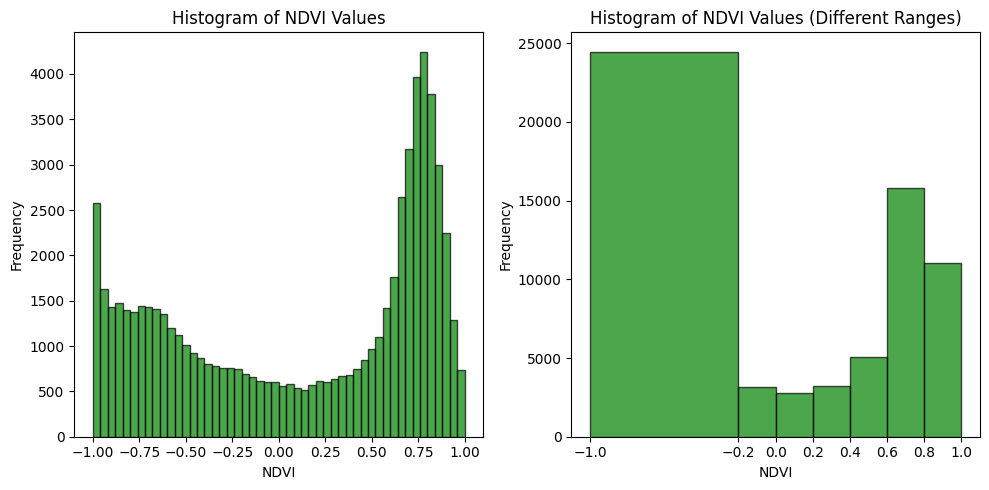

Mean NDVI: 0.3498255861416334
Median NDVI: 0.4926252943365784
Standard Deviation of NDVI: 0.3508216301775201


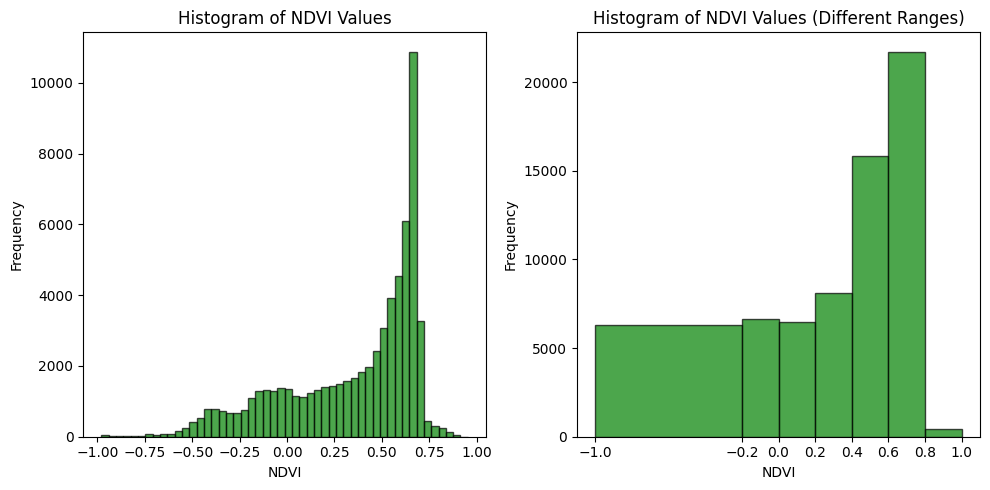

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def calculate_ndvi_statistics(ndvi_image_path):
    with rasterio.open(ndvi_image_path) as src:
        ndvi = src.read(1)  # Read the first band

    # Calculate statistics for the entire NDVI image
    mean_ndvi = np.mean(ndvi)
    median_ndvi = np.median(ndvi)
    std_ndvi = np.std(ndvi)

    # Print the statistics
    print(f'Mean NDVI: {mean_ndvi}')
    print(f'Median NDVI: {median_ndvi}')
    print(f'Standard Deviation of NDVI: {std_ndvi}')

    # Plot histogram of NDVI values
    plt.figure(figsize=(10, 5))

    # Plot histogram for entire image
    plt.subplot(1, 2, 1)
    plt.hist(ndvi.flatten(), bins=50, edgecolor='black', alpha=0.7, color='green')
    plt.title('Histogram of NDVI Values')
    plt.xlabel('NDVI')
    plt.ylabel('Frequency')

    # Plot histogram for different NDVI ranges
    plt.subplot(1, 2, 2)
    bins = [-1, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]  # Define bins for different NDVI ranges
    plt.hist(ndvi.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='green')
    plt.title('Histogram of NDVI Values (Different Ranges)')
    plt.xlabel('NDVI')
    plt.ylabel('Frequency')

    # Customize x-axis labels to show bin ranges
    plt.xticks(bins)

    plt.tight_layout()
    plt.show()

    return mean_ndvi, median_ndvi, std_ndvi

# Calculate statistics for reference and comparison NDVI images
mean_ref, median_ref, std_ref = calculate_ndvi_statistics('ndvi_output1.tif')
mean_comp, median_comp, std_comp = calculate_ndvi_statistics('ndvi_output2.tif')


In [ ]:
# Asparagus Growing Conditions

ideal_conditions = {
    'temperature': (16, 24),  # Suitable temperature range for asparagus in °C
    'precipitation': (50, 75)  # Suitable precipitation in cm annually
}

average_annual_conditions = {
    'temperature': 20,  # Average annual temperature in °C for asparagus growth
    'precipitation': 65  # Average annual precipitation in cm
}


Mean NDVI: 0.5612355730571039
Median NDVI: 0.6747907569252365
Standard Deviation of NDVI: 0.3358486941570861


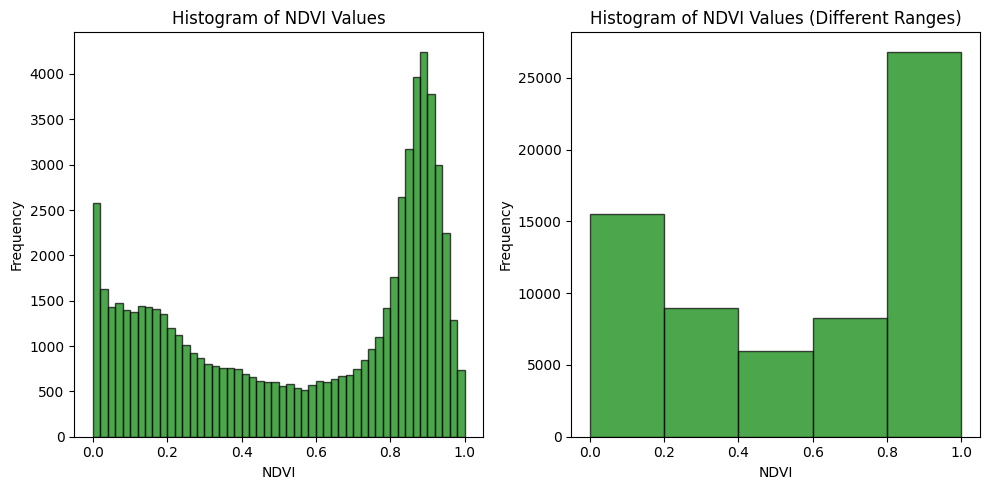

Mean NDVI: 0.6749127930708168
Median NDVI: 0.7463126471682893
Standard Deviation of NDVI: 0.17541081508876005


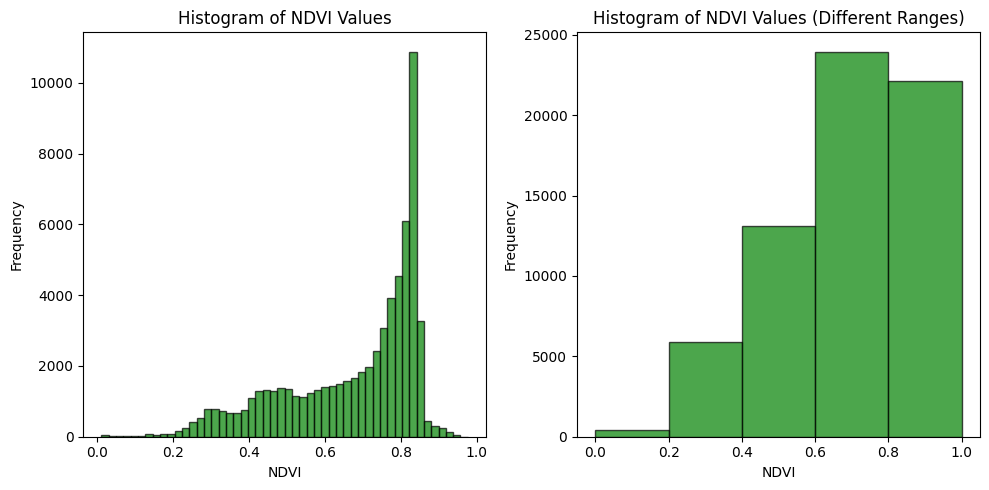

Best time to plant: 2024-07-01T06:00:00Z with a score of 46.14285714285714/100 (Poor)
Excellent: The conditions are nearly perfect for planting. The short-term weather forecast and average annual conditions are both highly favorable.
Good: The conditions are generally favorable for planting. There might be minor deviations from the ideal conditions, but they are still suitable.
Moderate: The conditions are acceptable but not ideal. Some factors might be less favorable, but planting is still possible with some care.
Poor: The conditions are generally unfavorable for planting. There are significant deviations from the ideal conditions.
Very Poor: The conditions are highly unsuitable for planting. It is not recommended to plant under these conditions.

Recommendations for improvement:
Temperature too low: Consider using greenhouses or row covers to retain heat. Planting early or late in the season can also help to avoid the coldest periods.
Temperature too high: Provide shade using shade 

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def calculate_ndvi_statistics(ndvi_image_path):
    with rasterio.open(ndvi_image_path) as src:
        ndvi = src.read(1)  # Read the first band

    # Scale NDVI values from -1 to 1 to 0 to 1
    ndvi = (ndvi + 1) / 2

    # Calculate statistics for the entire NDVI image
    mean_ndvi = np.mean(ndvi)
    median_ndvi = np.median(ndvi)
    std_ndvi = np.std(ndvi)

    # Print the statistics
    print(f'Mean NDVI: {mean_ndvi}')
    print(f'Median NDVI: {median_ndvi}')
    print(f'Standard Deviation of NDVI: {std_ndvi}')

    # Plot histogram of NDVI values
    plt.figure(figsize=(10, 5))

    # Plot histogram for entire image
    plt.subplot(1, 2, 1)
    plt.hist(ndvi.flatten(), bins=50, edgecolor='black', alpha=0.7, color='green')
    plt.title('Histogram of NDVI Values')
    plt.xlabel('NDVI')
    plt.ylabel('Frequency')

    # Plot histogram for different NDVI ranges
    plt.subplot(1, 2, 2)
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1]  # Define bins for different NDVI ranges
    plt.hist(ndvi.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='green')
    plt.title('Histogram of NDVI Values (Different Ranges)')
    plt.xlabel('NDVI')
    plt.ylabel('Frequency')

    # Customize x-axis labels to show bin ranges
    plt.xticks(bins)

    plt.tight_layout()
    plt.show()

    return mean_ndvi, median_ndvi, std_ndvi

# Calculate statistics for reference and comparison NDVI images
mean_ref, median_ref, std_ref = calculate_ndvi_statistics('ndvi_output1.tif')
mean_comp, median_comp, std_comp = calculate_ndvi_statistics('ndvi_output2.tif')

# Define the suitable weather conditions for the crop
ideal_conditions = {
    'temperature': (20, 30),  # Suitable temperature range in °C
    'precipitation': (30, 70)  # Suitable precipitation probability range in %
}
average_annual_conditions = {
    'temperature': 25,  # Average annual temperature in °C
    'precipitation': 50  # Average annual precipitation probability in %
}

def calculate_suitability_score(resampled_data, ideal_conditions, average_annual_conditions, weightage=0.4):
    temperature_range = ideal_conditions['temperature']
    precipitation_range = ideal_conditions['precipitation']

    # Define buffer ranges
    temp_buffer = 2  # Reduced buffer for more stringent scoring
    precip_buffer = 5  # Reduced buffer for more stringent scoring

    extended_temp_range = (temperature_range[0] - temp_buffer, temperature_range[1] + temp_buffer)
    extended_precip_range = (precipitation_range[0] - precip_buffer, precipitation_range[1] + precip_buffer)

    avg_annual_temp = average_annual_conditions['temperature']
    avg_annual_precip = average_annual_conditions['precipitation']

    scores = []

    for interval in resampled_data:
        temp = interval[1]
        precip = interval[2]

        temp_score = max(0, min(100, (100 * (temp - extended_temp_range[0]) / (extended_temp_range[1] - extended_temp_range[0]))))
        precip_score = max(0, min(100, (100 * (precip - extended_precip_range[0]) / (extended_precip_range[1] - extended_precip_range[0]))))

        overall_score = (temp_score + precip_score) / 2

        # Adjust overall score with annual average conditions
        annual_temp_score = max(0, min(100, (100 * (avg_annual_temp - extended_temp_range[0]) / (extended_temp_range[1] - extended_temp_range[0]))))
        annual_precip_score = max(0, min(100, (100 * (avg_annual_precip - extended_precip_range[0]) / (extended_precip_range[1] - extended_precip_range[0]))))
        annual_overall_score = (annual_temp_score + annual_precip_score) / 2

        adjusted_score = (1 - weightage) * overall_score + weightage * annual_overall_score

        scores.append((adjusted_score, temp, precip))

    return scores

def categorize_score(score):
    if 90 <= score <= 100:
        return "Excellent"
    elif 75 <= score <= 89:
        return "Good"
    elif 60 <= score <= 74:
        return "Moderate"
    elif 45 <= score <= 59:
        return "Poor"
    else:
        return "Very Poor"

def generate_recommendations(temp, precip, ideal_conditions):
    recommendations = []
    temp_range = ideal_conditions['temperature']
    precip_range = ideal_conditions['precipitation']

    if temp < temp_range[0]:
        recommendations.append("Temperature is too low. Consider using greenhouses or row covers to retain heat.")
    elif temp > temp_range[1]:
        recommendations.append("Temperature is too high. Consider providing shade or mulching to cool the soil.")

    if precip < precip_range[0]:
        recommendations.append("Precipitation is too low. Consider using mulching to retain soil moisture and irrigation to provide water.")
    elif precip > precip_range[1]:
        recommendations.append("Precipitation is too high. Ensure good drainage to avoid waterlogging.")

    return recommendations

# Example resampled data (to be replaced with actual data)
resampled_data = [
    ["2024-07-01T00:00:00Z", 22, 45],
    ["2024-07-01T03:00:00Z", 24, 50],
    ["2024-07-01T06:00:00Z", 26, 40],
    # Add more intervals as needed
]

# Calculate suitability scores for each interval
suitability_scores = calculate_suitability_score(resampled_data, ideal_conditions, average_annual_conditions)

# Determine the best time to plant based on suitability scores
best_time_to_plant = None
max_score = -1
best_interval = None

for i in range(0, len(suitability_scores), 2):
    avg_score = np.mean([s[0] for s in suitability_scores[i:i+2]])  # Average score for a 6-hour window
    if avg_score > max_score:
        max_score = avg_score
        best_time_to_plant = resampled_data[i][0]
        best_interval = suitability_scores[i]

category = categorize_score(max_score)

print(f'Best time to plant: {best_time_to_plant} with a score of {max_score}/100 ({category})')

recommendations = generate_recommendations(best_interval[1], best_interval[2], ideal_conditions)

# Display categories and descriptions
categories = {
    "Excellent": "The conditions are nearly perfect for planting. The short-term weather forecast and average annual conditions are both highly favorable.",
    "Good": "The conditions are generally favorable for planting. There might be minor deviations from the ideal conditions, but they are still suitable.",
    "Moderate": "The conditions are acceptable but not ideal. Some factors might be less favorable, but planting is still possible with some care.",
    "Poor": "The conditions are generally unfavorable for planting. There are significant deviations from the ideal conditions.",
    "Very Poor": "The conditions are highly unsuitable for planting. It is not recommended to plant under these conditions."
}

for cat, desc in categories.items():
    print(f"{cat}: {desc}")

# Print recommendations
print("\nRecommendations for improvement:")
for rec in recommendations:
    print(f"- {rec}")

# Default suggestions for improvement based on general conditions
default_suggestions = {
    "Temperature too low": "Consider using greenhouses or row covers to retain heat. Planting early or late in the season can also help to avoid the coldest periods.",
    "Temperature too high": "Provide shade using shade cloth or other structures. Mulching can help to cool the soil and retain moisture.",
    "Precipitation too low": "Implement irrigation systems to ensure adequate water supply. Mulching can help retain soil moisture.",
    "Precipitation too high": "Ensure good drainage to prevent waterlogging. Raised beds can help in areas with high rainfall."
}

for condition, suggestion in default_suggestions.items():
    print(f"{condition}: {suggestion}")

# Estimate improvement in score based on adjustments
def estimate_score_improvement(current_score, adjustment_factor):
    return current_score * adjustment_factor

# Example of estimating score improvement for temperature adjustment
current_score = max_score  # Use the current maximum score as an example
temperature_improvement_factor = 0.3  # Hypothetical improvement factor for adjusting temperature
precipitation_improvement_factor = 0.2  # Hypothetical improvement factor for adjusting precipitation

improvement_temperature = estimate_score_improvement(current_score, temperature_improvement_factor)
improvement_precipitation = estimate_score_improvement(current_score, precipitation_improvement_factor)

print(f"\nEstimated score improvement with temperature adjustment: {improvement_temperature}")
print(f"Estimated score improvement with precipitation adjustment: {improvement_precipitation}")


In [ ]:
import requests
from tabulate import tabulate
from datetime import datetime, timedelta
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Your Tomorrow.io API key
api_key = 'qbSV5dCwZ1n1PyNlcy1a9oH0cd9X7cAj'

# Base URL for the Tomorrow.io API
base_url = 'https://api.tomorrow.io/v4/timelines'

# Calculate start and end times
start_time = datetime.now().isoformat()  # current time
end_time = (datetime.now() + timedelta(days=5)).isoformat()  # 5 days from now

# Parameters for the request
params = {
    'apikey': api_key,
    'location': '13.1377,78.1297',  # Coordinates for Kolar, Karnataka
    'fields': ['temperature', 'precipitationProbability'],
    'timesteps': '1h',
    'startTime': start_time,
    'endTime': end_time
}

# Make the request to Tomorrow.io API
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    timeline_intervals = data['data']['timelines'][0]['intervals']
    table_data = []

    for interval in timeline_intervals:
        time = interval['startTime']
        temperature = interval['values']['temperature']
        precipitation = interval['values']['precipitationProbability']
        table_data.append([time, temperature, precipitation])

    # Print detailed hourly data
    print("Detailed Hourly Data:")
    headers = ["Time", "Temperature (°C)", "Precipitation Probability (%)"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Calculate NDVI statistics function
    def calculate_ndvi_statistics(ndvi_image_path):
        with rasterio.open(ndvi_image_path) as src:
            ndvi = src.read(1)  # Read the first band

        # Scale NDVI values from -1 to 1 to 0 to 1
        ndvi = (ndvi + 1) / 2

        # Calculate statistics for the entire NDVI image
        mean_ndvi = np.mean(ndvi)
        median_ndvi = np.median(ndvi)
        std_ndvi = np.std(ndvi)

        return mean_ndvi, median_ndvi, std_ndvi

    # Example NDVI statistics calculation for reference and comparison
    mean_ref, median_ref, std_ref = calculate_ndvi_statistics('ndvi_output1.tif')
    mean_comp, median_comp, std_comp = calculate_ndvi_statistics('ndvi_output2.tif')

    # Chayote Growing Conditions

    # Celeriac Growing Conditions

    # Asparagus Growing Conditions

    ideal_conditions = {
        'temperature': (16, 24),  # Suitable temperature range for asparagus in °C
        'precipitation': (50, 75)  # Suitable precipitation in cm annually
    }

    average_annual_conditions = {
        'temperature': 20,  # Average annual temperature in °C for asparagus growth
        'precipitation': 65  # Average annual precipitation in cm
    }



    def calculate_suitability_score(table_data, ideal_conditions, average_annual_conditions, weightage=0.4):
        temperature_range = ideal_conditions['temperature']
        precipitation_range = ideal_conditions['precipitation']

        # Define buffer ranges
        temp_buffer = 2  # Reduced buffer for more stringent scoring
        precip_buffer = 5  # Reduced buffer for more stringent scoring

        extended_temp_range = (temperature_range[0] - temp_buffer, temperature_range[1] + temp_buffer)
        extended_precip_range = (precipitation_range[0] - precip_buffer, precipitation_range[1] + precip_buffer)

        avg_annual_temp = average_annual_conditions['temperature']
        avg_annual_precip = average_annual_conditions['precipitation']

        scores = []

        for interval in table_data:
            temp = interval[1]
            precip = interval[2]

            temp_score = max(0, min(100, (100 * (temp - extended_temp_range[0]) / (extended_temp_range[1] - extended_temp_range[0]))))
            precip_score = max(0, min(100, (100 * (precip - extended_precip_range[0]) / (extended_precip_range[1] - extended_precip_range[0]))))

            overall_score = (temp_score + precip_score) / 2

            # Adjust overall score with annual average conditions
            annual_temp_score = max(0, min(100, (100 * (avg_annual_temp - extended_temp_range[0]) / (extended_temp_range[1] - extended_temp_range[0]))))
            annual_precip_score = max(0, min(100, (100 * (avg_annual_precip - extended_precip_range[0]) / (extended_precip_range[1] - extended_precip_range[0]))))
            annual_overall_score = (annual_temp_score + annual_precip_score) / 2

            adjusted_score = (1 - weightage) * overall_score + weightage * annual_overall_score

            scores.append((adjusted_score, temp, precip))

        return scores

    def categorize_score(score):
        if 90 <= score <= 100:
            return "Excellent"
        elif 75 <= score <= 89:
            return "Good"
        elif 60 <= score <= 74:
            return "Moderate"
        elif 45 <= score <= 59:
            return "Poor"
        else:
            return "Very Poor"

    def generate_recommendations(temp, precip, ideal_conditions):
        recommendations = []
        temp_range = ideal_conditions['temperature']
        precip_range = ideal_conditions['precipitation']

        if temp < temp_range[0]:
            recommendations.append("Temperature is too low. Consider using greenhouses or row covers to retain heat.")
        elif temp > temp_range[1]:
            recommendations.append("Temperature is too high. Consider providing shade or mulching to cool the soil.")

        if precip < precip_range[0]:
            recommendations.append("Precipitation is too low. Consider using mulching to retain soil moisture and irrigation to provide water.")
        elif precip > precip_range[1]:
            recommendations.append("Precipitation is too high. Ensure good drainage to avoid waterlogging.")

        return recommendations

    # Calculate suitability scores for each hourly interval
    suitability_scores = calculate_suitability_score(table_data, ideal_conditions, average_annual_conditions)

    # Determine the best time to plant based on suitability scores
    best_time_to_plant = None
    max_score = -1
    best_interval = None

    for i, interval in enumerate(suitability_scores):
        score, temp, precip = interval
        if score > max_score:
            max_score = score
            best_time_to_plant = table_data[i][0]
            best_interval = interval

    category = categorize_score(max_score)

    print(f'\nBest time to plant: {best_time_to_plant} with a score of {max_score:.2f}/100 ({category})')

    recommendations = generate_recommendations(best_interval[1], best_interval[2], ideal_conditions)

    # Display categories and descriptions
    categories = {
        "Excellent": "The conditions are nearly perfect for planting. The short-term weather forecast and average annual conditions are both highly favorable.",
        "Good": "The conditions are generally favorable for planting. There might be minor deviations from the ideal conditions, but they are still suitable.",
        "Moderate": "The conditions are acceptable but not ideal. Some factors might be less favorable, but planting is still possible with some care.",
        "Poor": "The conditions are generally unfavorable for planting. There are significant deviations from the ideal conditions.",
        "Very Poor": "The conditions are highly unsuitable for planting. It is not recommended to plant under these conditions."
    }

    for cat, desc in categories.items():
        print(f"{cat}: {desc}")

    # Print recommendations
    print("\nRecommendations for improvement:")
    for rec in recommendations:
        print(f"- {rec}")

    # Default suggestions for improvement based on general conditions
    default_suggestions = {
        "Temperature too low": "Consider using greenhouses or row covers to retain heat. Planting early or late in the season can also help to avoid the coldest periods.",
        "Temperature too high": "Provide shade using shade cloth or other structures. Mulching can help to cool the soil and retain moisture.",
        "Precipitation too low": "Implement irrigation systems to ensure adequate water supply. Mulching can help retain soil moisture.",
        "Precipitation too high": "Ensure good drainage to prevent waterlogging. Raised beds can help in areas with high rainfall."
    }

    for condition, suggestion in default_suggestions.items():
        print(f"{condition}: {suggestion}")

    # Estimate improvement in score based on adjustments
    def estimate_score_improvement(current_score, adjustment_factor):
        return current_score * adjustment_factor

    # Example of estimating score improvement for temperature adjustment
    current_score = max_score  # Use the current maximum score as an example
    temperature_improvement_factor = 0.3  # Hypothetical improvement factor for adjusting temperature
    precipitation_improvement_factor = 0.2
    # Hypothetical improvement factor for adjusting precipitation

    improvement_temperature = estimate_score_improvement(current_score, temperature_improvement_factor)
    improvement_precipitation = estimate_score_improvement(current_score, precipitation_improvement_factor)

    print(f"\nEstimated score improvement with temperature adjustment: {improvement_temperature:.2f}")
    print(f"Estimated score improvement with precipitation adjustment: {improvement_precipitation:.2f}")

else:
    print(f'Error: {response.status_code}, {response.text}')


Detailed Hourly Data:
+----------------------+--------------------+---------------------------------+
| Time                 |   Temperature (°C) |   Precipitation Probability (%) |
+======================+====================+=================================+
| 2024-07-23T04:00:00Z |              25.31 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T05:00:00Z |              25.17 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T06:00:00Z |              27.03 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T07:00:00Z |              27.09 |                               0 |
+----------------------+--------------------+---------------------------------+
| 2024-07-23T08:00:00Z |              27.44 |                              10 |
+-----------------

In [ ]:
import csv
import tempfile

# Function to generate CSV
def generate_csv(filename, mean_ndvi, median_ndvi, std_ndvi, best_time_to_plant, max_score, category):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write header
        writer.writerow(['Statistic', 'Value'])

        # Write statistics
        writer.writerow(['Mean NDVI', mean_ndvi])
        writer.writerow(['Median NDVI', median_ndvi])
        writer.writerow(['Standard Deviation of NDVI', std_ndvi])

        # Write suitability score details
        writer.writerow([])
        writer.writerow(['Best Time to Plant', best_time_to_plant])
        writer.writerow(['Score', f'{max_score}/100'])
        writer.writerow(['Category', category])

# Generate CSV
csv_filename = 'crop_recommendations.csv'
generate_csv(csv_filename, mean_ndvi, median_ndvi, std_ndvi, best_time_to_plant, max_score, category)

print(f'CSV file "{csv_filename}" generated successfully.')

CSV file "crop_recommendations.csv" generated successfully.
